<a href="https://colab.research.google.com/github/nmermigas/PyTorch/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Workflow

Let's explore an example Pytorch end-to-end workflow.


In [14]:
what_were_covering = {1:'data (prepare and load)',
                      2: 'build model',
                      3: 'fitting the model to data (training)',
                      4: 'making predictions and evaluating the model',
                      5: 'saving and loading a model',
                      6: 'putting it all together'}

In [15]:
import torch
from torch import nn # contains all of Pytorch's building blocks for nn
import matplotlib.pyplot as plt


# Check Pytorch version
torch.__version__

'2.0.1+cu118'

## Data (prepare and load)

Data can be almost anything in ML.

* Excel spreadsheet
* Images of any kind
* Videos (YT...)
* Audio like songs or podcasts
* DNA
* Text

ML is a game of two parts:

1. Get data into a numerical representation
2. Build model to learn patterns in numbers

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with known **parameters**

In [16]:
# Create known parameters
weight = 0.7 # b in the linear regression
bias = 0.3 # a in the linear regression

start = 0
end = 1

step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias

X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [17]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

In [18]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test),len(y_train), len(y_test)


(40, 10, 40, 10)

Visualizing data.

In [19]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  Plots training data, test data and compares predictions
  """
  plt.figure(figsize=(10,7))

  #Plot training data in blue
  plt.scatter(train_data,train_labels, c='b',s=4,label= "Training Data")

  # Plot test data in green
  plt.scatter(test_data,test_labels,c="g",s=4,label ="Testing Data")

  if predictions is not None:
    plt.scatter(test_data,predictions, c='r',s=4,label = "Predictions")

  plt.legend(prop={'size':14})

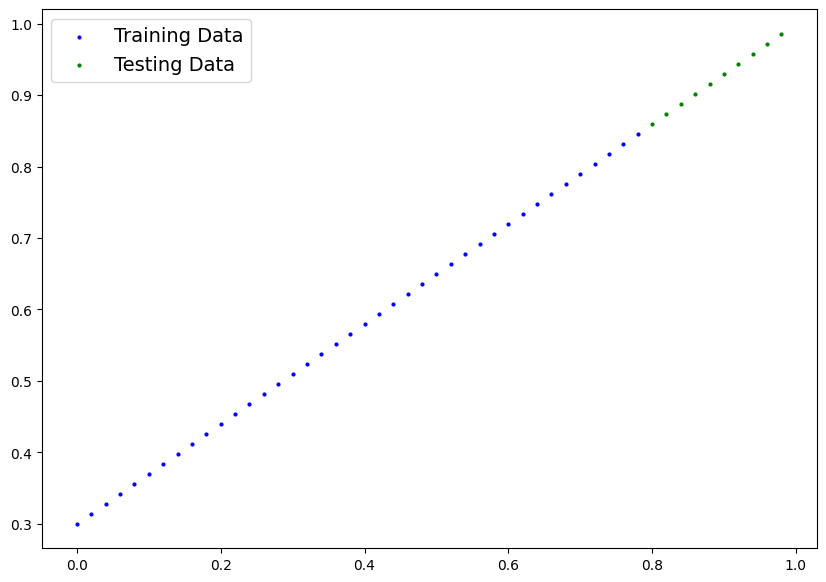

In [20]:
plot_predictions();

## 2. Build model
Real python link: https://realpython.com/python3-object-oriented-programming/

What the model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent the ideal values (weight & bias).

How?

Through two main algorithms:
1. Gradient Descent
2. Backpropagation

In [21]:
from torch import nn

# Create linear regression model class
class LinearRegressionModel(nn.Module): # almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # start with a random weight and try to adjust.
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, # start with a random bias and try to adjust.
                                         requires_grad=True,
                                         dtype=torch.float))

    #Forward method to define the computation in the model. We need to override the forward method if we use the nn module

  def forward(self, x:torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs ( a nn can be considered one)

* torch.nn.Parameter - what parameters should our model try and learn.

* torch.nn.Module - The base class for all neural networks for all neural network modules, if you subclass it, you should overwrite forward()

* torch.optim - this is where the PyTorch optimizers live, helping with Gradient Descent

* def forward() - All nn.Module subclasses need to overwrite it

### Checking the contents of our PyTorch model

Now we've created the model, let's see inside.

We can check our model parameters or what is inside the model using `.parameters()`

In [22]:
# Create a random seed (deterministic)

torch.manual_seed(42)

# Create an instance of the modle (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [23]:
# List named parameters

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the `forward()` method

In [24]:
# Make predictions with model

#The preferred way.
with torch.inference_mode():
  y_preds = model_0(X_test)

# Something similar with torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [25]:
#Or

y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

## 3. Train model

The whole idea of training is for a model to move from some unkown parameters (may be random) to some known parameters.

Or, in other words, from a poor representation of the data to a better representation of the data.

One way to measure how poor or wrong the model predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areaas. For our case, we're going to refer to it as a loss function.

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.

* **Optimizer:** Takes into account the loss of a model and asjusts the model's parameters to improve the loss function.
  * Parameters of the optimizer (usually):
    * `params`: the parameters to be optimized
    * `lr`: learning rate

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [26]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [27]:
# Check out our model's parameter
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [28]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stohastic gradient descent)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01 ) # lr = learning rate (important hyperparameter)

### Building a training and a testing loop in PyTorch

A couple of things we need in a training loop:

0. Loop through the data and do...
1. Forward pass (this involves data moving through the model's `forward()` methods) to make predictions on data - also called `forward propagation`
2. Calculate the loss (compare forwards pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our the model with respect to the loss, also called **backpropagation**
5. Optimizer step - use the optimizerto adjust our model's parameters to try and improve the loss (**gradient descend**)

In [29]:
torch.manual_seed(42)
# An epoch is one loop through the data... (hyperparameter)
epochs = 200

# track different values
epoch_count =[]
loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters tha require gradients to require gradients.

  # 1. Forward pass
  y_pred = model_0(X_train)

  #2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  # print("Loss:",loss)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so... wh have to zero them above

  ### Testing

  model_0.eval()  # turns off different setting in the model not needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode():# turns off gradient tracking and a couple other things
    # 1. Forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
  if (epoch % 10 == 0):
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss:{loss} | Test loss: {test_loss}")
    print(model_0.state_dict())

    # 3.



Epoch: 0 | Loss:0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss:0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss:0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss:0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss:0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss:0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss:0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788]))])
E

In [30]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

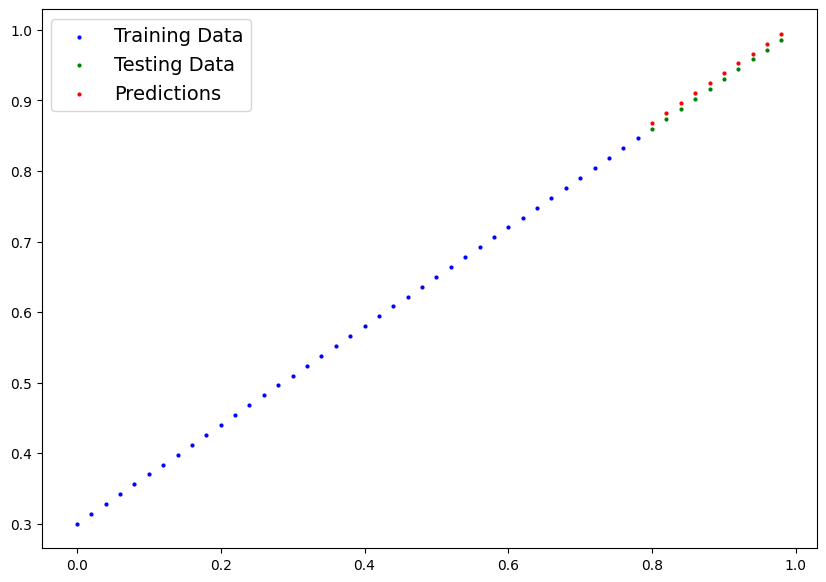

In [31]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)
plot_predictions(predictions=y_preds_new)

In [32]:
epoch_count,loss_values,test_loss_values

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190],
 [tensor(0.3129, grad_fn=<MeanBackward0>),
  tensor(0.1977, grad_fn=<MeanBackward0>),
  tensor(0.0891, grad_fn=<MeanBackward0>),
  tensor(0.0531, grad_fn=<MeanBackward0>),
  tensor(0.0454, grad_fn=<MeanBackward0>),
  tensor(0.0417, grad_fn=<MeanBackward0>),
  tensor(0.0382, grad_fn=<MeanBackward0>),
  tensor(0.0348, grad_fn=<MeanBackward0>),
  tensor(0.0313, grad_fn=<MeanBackward0>),
  tensor(0.0279, grad_fn=<MeanBackward0>),
  tensor(0.0245, grad_fn=<MeanBackward0>),
  tensor(0.0210, grad_fn=<MeanBackward0>),
  tensor(0.0176, grad_fn=<MeanBackward0>),
  tensor(0.0142, grad_fn=<MeanBackward0>),
  tensor(0.0107, grad_fn=<MeanBackward0>),
  tensor(0.0073, grad_fn=<MeanBackward0>),
  tensor(0.0039, grad_fn=<MeanBackward0>),
  tensor(0.0089, grad_fn=<MeanBackward0>),
  tensor(0.0089, grad_fn=<MeanBackward0>),
  tensor(0.0089, grad_fn=<MeanBackward0>)],
 [tensor(

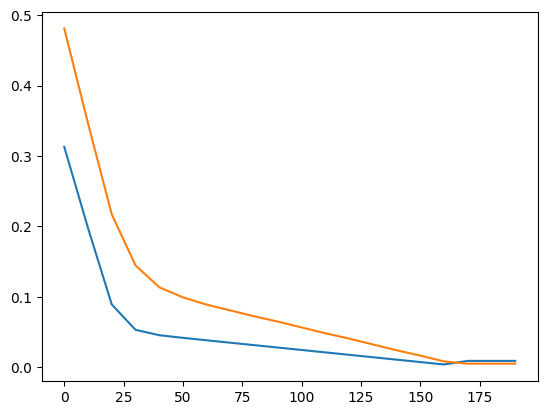

In [33]:
import numpy as np

plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu()),label = "Train loss")
plt.plot(epoch_count, test_loss_values,label = "Test loss")


## 4. Saving a model in PyTorch

There are three main methods to save and load models in PyTorch..

1. `torch.save()` - allows to save a PyTorch object in Python's `pickle` format.

2. `torch.load()` - allows to load a saved PyTorch object.

3. `torch.nn.Module.load_state_dict()` - alllows to load a model's saved `state dictionary`

In [34]:
from pathlib import Path

# 1. Create modles directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents = True,exist_ok = True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model (the model's state_dict)
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [35]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1207 Oct  7 17:29 01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and pass `state_dict()` into that.

In [36]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0(this will update the new instance with the updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [37]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [38]:
# Make predictions with the loaded model

loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [39]:
# Make predictions with the original model
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

In [40]:
# Compare the 2 models
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together


In [77]:
# improts
import torch
from torch import nn
import matplotlib.pyplot as plt

#Check PyTorch version
torch.__version__

'2.0.1+cu118'

Create device-agnostic code.

This means: If we have access to a GPU, our code will use it (for potentially faster computing).

If no GPU is available, the code will default to using CPU.

In [78]:
# Setup device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


### 6.1 Data

In [79]:
# Create some data using the linear regression formula of y = weight * X + bias

weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start,end,step).unsqueeze(dim=1) # without it, errors will occur

y = weight * X + bias
X,y

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800],
         [0.2000],
         [0.2200],
         [0.2400],
         [0.2600],
         [0.2800],
         [0.3000],
         [0.3200],
         [0.3400],
         [0.3600],
         [0.3800],
         [0.4000],
         [0.4200],
         [0.4400],
         [0.4600],
         [0.4800],
         [0.5000],
         [0.5200],
         [0.5400],
         [0.5600],
         [0.5800],
         [0.6000],
         [0.6200],
         [0.6400],
         [0.6600],
         [0.6800],
         [0.7000],
         [0.7200],
         [0.7400],
         [0.7600],
         [0.7800],
         [0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.3000],
         [0.3140],
         [

In [80]:
# Split data
train_split = int(0.8 * len(X))
X_train,y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

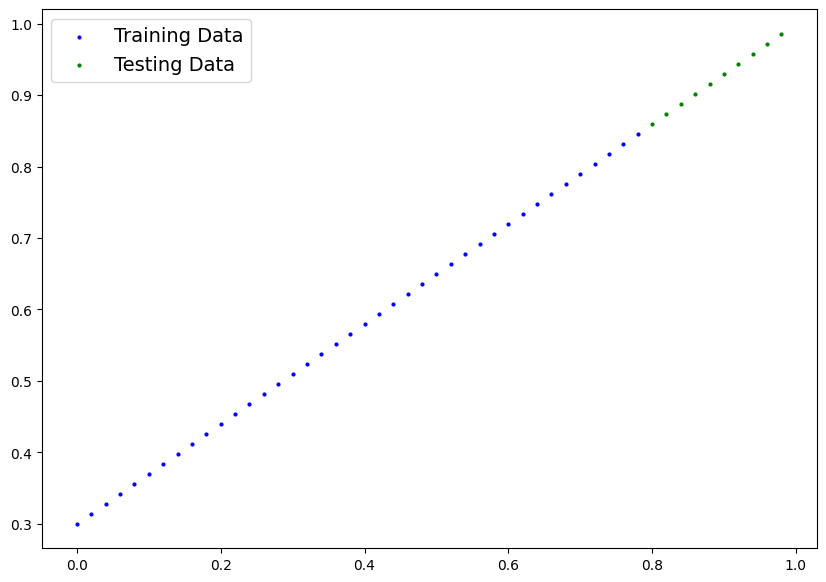

In [81]:
# Plot the data
plot_predictions(X_train,y_train,X_test,y_test)

### 6.2 Building a PyTorch linear model

In [82]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [83]:
#Check thje model current device
next(model_1.parameters()).device

device(type='cpu')

In [84]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device


device(type='cuda', index=0)

### 6.3 Train the model

For training we need:
* Loss function
* Optimizer
* Training Loop
* Testing Loop

In [85]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

#Setup the optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.01)


In [86]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = X_test.to(device)


for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer no grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing

  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred,y_test)

    #Print what's happening

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")


Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.6069762706756592
Epoch: 10 | Loss: 0.439968079328537 | Test Loss: 0.47226640582084656
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.3375565707683563
Epoch: 30 | Loss: 0.20954833924770355 | Test Loss: 0.2028467208147049
Epoch: 40 | Loss: 0.09433845430612564 | Test Loss: 0.06813690066337585
Epoch: 50 | Loss: 0.023886388167738914 | Test Loss: 0.023275597020983696
Epoch: 60 | Loss: 0.019956795498728752 | Test Loss: 0.021817976608872414
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss: 0.019164402037858963
Epoch: 80 | Loss: 0.013089174404740334 | Test Loss: 0.01817154325544834
Epoch: 90 | Loss: 0.009653178043663502 | Test Loss: 0.019074415788054466
Epoch: 100 | Loss: 0.006215683650225401 | Test Loss: 0.021886223927140236
Epoch: 110 | Loss: 0.00278724217787385 | Test Loss: 0.02736755646765232
Epoch: 120 | Loss: 0.0012645035749301314 | Test Loss: 0.02134581282734871
Epoch: 130 | Loss: 0.0012645035749301314 | Test Loss: 0.0213458128273

In [87]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

 ### 6.4 Making and evaluatring predictions

In [88]:
# Turn model into evaluiation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

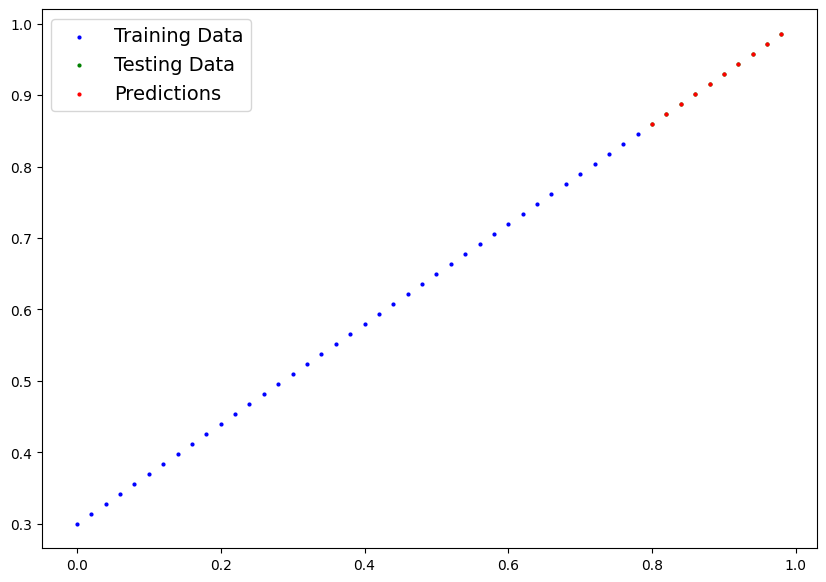

In [89]:
# Check out our model predictions visually
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving and loading a trained model

In [94]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. Create model save path

MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [97]:
# Load the model

# Create a new instance of the regression model V2
loaded_model_1 = LinearRegressionModelV2()

# load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [100]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [101]:
# Evaluate loaded model

loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')